In [1]:
%pylab inline

import gc
import fpfs
import numpy as np
import matplotlib.pylab as plt
import astropy.io.fits as pyfits
from fpfs.imgutil import gauss_kernel
from fpfs import simutil

Populating the interactive namespace from numpy and matplotlib
Do not have lsst pipeline!


In [2]:
def test_randomref(igroup=0,do_plot=False):
    ngrid=64
    if igroup>=0:
        ngal=100
        img1=pyfits.getdata('../../FPFS2/sim/galaxy_basicShift_psf60/image-%d-g1-0000.fits' %igroup)
        img2=pyfits.getdata('../../FPFS2/sim/galaxy_basicShift_psf60/image-%d-g1-2222.fits' %igroup)
    else:
        ngal=20
        img1=simutil.make_basic_sim('basicShift_psf60','g1-0000',0,ny=ngal,nx=ngal,do_write=False)
        img2=simutil.make_basic_sim('basicShift_psf60','g1-2222',0,ny=ngal,nx=ngal,do_write=False)
    ngrid2=ngrid*ngal

    # PSF
    psf=pyfits.getdata('../../FPFS2/sim/galaxy_basic_psf60/psf-60.fits')
    npad       =   (ngrid2-psf.shape[0])//2
    psfData    =   np.pad(psf,(npad+1,npad),mode='constant')
    assert psfData.shape[0]==ngrid2
    psfF=np.fft.fft2(np.fft.ifftshift(psfData))
    gsigma=3.*2.*np.pi/64
    x   = np.fft.fftfreq(ngrid2,1/np.pi/2.)

    gKer,grids=gauss_kernel(ngrid2,ngrid2,gsigma,return_grid=True)
    k2grid,k1grid=grids

    imgF1=np.fft.fft2(img1)/psfF*gKer
    imgFQA1=imgF1*(k1grid**2.-k2grid**2.)/gsigma**2.
    imgFQB1=imgF1*(2.*k1grid*k2grid)/gsigma**2.
    imgFDA1=imgF1*(-1j*k1grid)
    imgFDB1=imgF1*(-1j*k2grid)

    imgF2=np.fft.fft2(img2)/psfF*gKer
    imgFQA2=imgF2*(k1grid**2.-k2grid**2.)/gsigma**2.
    imgFQB2=imgF2*(2.*k1grid*k2grid)/gsigma**2.
    imgFDA2=imgF2*(-1j*k1grid)
    imgFDB2=imgF2*(-1j*k2grid)

    imgCov1=np.fft.ifft2(imgF1).real
    imgCovQA1=np.fft.ifft2(imgFQA1).real
    imgCovQB1=np.fft.ifft2(imgFQB1).real
    imgCovDA1=np.fft.ifft2(imgFDA1).real
    imgCovDB1=np.fft.ifft2(imgFDB1).real

    imgCov2=np.fft.ifft2(imgF2).real
    imgCovQA2=np.fft.ifft2(imgFQA2).real
    imgCovQB2=np.fft.ifft2(imgFQB2).real
    imgCovDA2=np.fft.ifft2(imgFDA2).real
    imgCovDB2=np.fft.ifft2(imgFDB2).real

    if do_plot:
        y1grid,x1grid = np.meshgrid(np.fft.fftfreq(ngrid,1/ngrid),np.fft.fftfreq(ngrid,1/ngrid),indexing='ij')
        x1grid=np.fft.fftshift(x1grid)
        y1grid=np.fft.fftshift(y1grid)

        dpad=0
        ii=1;jj=2
        fig=plt.figure(figsize=(10,5))
        ax=fig.add_subplot(1,2,1)
        ax.imshow(img1[jj*64+dpad:(jj+1)*64-dpad,ii*64+dpad:(ii+1)*64-dpad],origin='lower',cmap='gray')
        ax.set_axis_off()
        ax=fig.add_subplot(1,2,2)
        ax.imshow(imgCov1[jj*64+dpad:(jj+1)*64-dpad,ii*64+dpad:(ii+1)*64-dpad],origin='lower',cmap='gray')
        ax.set_axis_off()
        plt.tight_layout()
        print(np.sum(img1[jj*64:(jj+1)*64,ii*64:(ii+1)*64]*x1grid)/np.sum(img1[jj*64:(jj+1)*64,ii*64:(ii+1)*64]))
        print(np.sum(img1[jj*64:(jj+1)*64,ii*64:(ii+1)*64]*y1grid)/np.sum(img1[jj*64:(jj+1)*64,ii*64:(ii+1)*64]))

    indX=np.arange(32,6400,64)
    indY=np.arange(32,6400,64)
    ind1=np.ix_(indY,indX)
    ind2=np.ix_(indY,indX)

    res1=imgCovQA1[ind1]#+0.5*imgCovDA1[ind1]-0.5*imgCovDB1[ind1]
    res2=imgCovQA2[ind2]#+0.5*imgCovDA2[ind2]-0.5*imgCovDB2[ind2]
    response=np.average((res1+res2)/2.)
    meas1=imgCov1[ind1]
    meas2=imgCov2[ind2]
    resEst=np.average((meas2-meas1)/0.04)
    return response,resEst

In [3]:
resAll=[]
resEstAll=[]
for ii in range(10):
    r,rEst=test_randomref(igroup=ii,do_plot=False)
    print(r,rEst)
    resAll.append(r)
    resEstAll.append(rEst)
    del r,rEst
    gc.collect()

-0.0029949521015140354 -0.006001904047995989
-6.378113201004889e-05 -0.0001235239137412898
-0.0007509245387564684 -0.0008341029221364833
0.0013427508426418647 0.0013817783648005714
-0.0018698310505889893 -0.0019213686428783574
0.0012432690780327202 0.0012397832795154012
-0.0012131909697602515 -0.0012312740041108443
0.0003966040440720528 0.00045090604777084066
0.0029722435802117396 0.003035668070598624
0.00011963491954804249 0.00011909398008121527


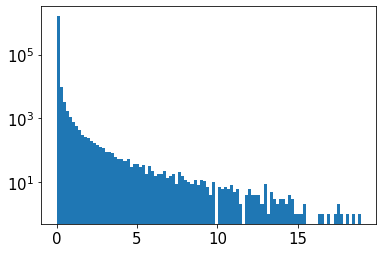

In [ ]:
plt.hist(np.ravel(imgCov1),bins=100)
plt.yscale('log')